# Model-based diffuser

In [23]:
import jax
import chex
from jax import lax
from jax import numpy as jnp
from flax import struct
import matplotlib.pyplot as plt
from IPython.display import clear_output, display
from tensorboardX import SummaryWriter

In [24]:
# initialize tensorboard
writer = SummaryWriter()

Initialize the parameters

In [25]:
obstacle = 'sphere' # sphere, umaze, square, wall
task = 'drone' # point, drone
# global static parameters
n_state: int = {'point': 4, 'drone': 6}[task]
n_action: int = 2
horizon: int = 50
diffuse_step = 1 #50
diffuse_substeps = 500 #20
batch_size = 64
saved_batch_size = 16

# schedule langevin episilon
langevin_eps_schedule = jnp.linspace(10.0, 0.5, diffuse_substeps) * 1e-7
if obstacle == 'umaze':
    langevin_eps_schedule = langevin_eps_schedule * 0.3 # NOTE: umaze needs smaller step size

# schedule global noise (perturbation noise)
# noise_var_init = 1e-2
# noise_var_init = 1e-4
# noise_var_final = 1e-4
noise_var_init = 4e-3
noise_var_final = 4e-3
# plan in exponential space
scale = 7.0
noise_var_schedule = jnp.exp(jnp.linspace(scale,0.0,diffuse_step))/jnp.exp(scale)
noise_var_schedule = noise_var_schedule * (noise_var_init - noise_var_final) + noise_var_final
# noise_std_schedule = jnp.linspace(noise_std_init, noise_std_final, diffuse_step)

In [29]:
def default_array(array):
    return struct.field(default_factory=lambda: jnp.array(array))

@struct.dataclass
class Params:
    # environment parameters
    dt: float = 0.2
    r_obs: float = 0.2
    init_state: jnp.ndarray = default_array(
        {
            'point': [-1.0, 0.0, 0.0, 0.0],
            'drone': [-1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
        }[task]
    )
    goal_state: jnp.ndarray = default_array(
        {
            'point': [1.0, 0.0, 0.0, 0.0],
            'drone': [1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
        }[task]
    )

    # diffuser parameters
    noise_var: float = 1.0
    langevin_eps: float = 1.0
    dyn_scale: float = 1.0
    reward_scale: float = 0.02
    barrier_scale: float = 5.0e2
    final_scale: float = 1

In [27]:
def get_A_point(x: jnp.ndarray, params: Params) -> jnp.ndarray:
    return jnp.array(
        [
            [0.0, 0.0, 1.0, 0.0],
            [0.0, 0.0, 0.0, 1.0],
            [0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0],
        ]
    ) * params.dt + jnp.eye(n_state)


def get_B_point(x: jnp.ndarray, params: Params) -> jnp.ndarray:
    return (
        jnp.array(
            [
                [0.0, 0.0],
                [0.0, 0.0],
                [1.0, 0.0],
                [0.0, 1.0],
            ]
        )
        * params.dt
    )

def get_A_drone(x: jnp.ndarray, params: Params) -> jnp.ndarray:
    return jnp.array(
        [
            [0.0, 0.0, 0.0, 1.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 0.0, 1.0],
            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
            [0.0, 0.0, 0.0, 0.0, 0.0, 0.0],
        ]
    ) * params.dt + jnp.eye(n_state)

def get_B_drone(x: jnp.ndarray, params: Params) -> jnp.ndarray:
    return jnp.array(
            [
                [0.0, 0.0],
                [0.0, 0.0],
                [0.0, 0.0],
                [jnp.cos(x[2]), 0.0],
                [jnp.sin(x[2]), 0.0],
                [0.0, 1.0],
            ]
        ) * params.dt

get_A = {'point': get_A_point, 'drone': get_A_drone}[task]
get_B = {'point': get_B_point, 'drone': get_B_drone}[task]

def rollout(x0: jnp.ndarray, u: jnp.ndarray, params: Params) -> jnp.ndarray:
    def f(x, u):
        return get_A(x, params) @ x + get_B(x, params) @ u, x

    _, x_seq = lax.scan(f, x0, u)
    return jnp.concatenate([x0[None, :], x_seq], axis=0)

dynamic related functions

In [28]:
Q = {
    'point': jnp.diag(jnp.array([10.0, 10.0, 1.0, 1.0])),
    'drone': jnp.diag(jnp.array([10.0, 10.0, 10.0, 1.0, 1.0, 1.0])),
}[task]
R = {
    'point': jnp.eye(n_action) * 0.1,
    'drone': jnp.eye(n_action) * 0.1,
}[task]

def get_reward(
    x_traj: jnp.ndarray,
    u_traj: jnp.ndarray,
    params: Params,
) -> jnp.ndarray:
    def get_running_cost(x: jnp.ndarray, u: jnp.ndarray) -> jnp.ndarray:
        x_err = x - params.goal_state   
        return (u @ R @ u) / 2.0

    running_cost = jax.vmap(get_running_cost)(x_traj, u_traj).sum()
    return -running_cost.sum()

def get_final_constraint(x_traj: jnp.ndarray, params: Params) -> jnp.ndarray:
    final_err = x_traj[-1] - params.goal_state
    final_cost = final_err @ Q @ final_err
    return -final_cost

def get_barrier_sphere(x_traj: jnp.ndarray, params: Params) -> jnp.ndarray:
    def get_barrier_cost(x: jnp.ndarray) -> jnp.ndarray:
        dist2center = jnp.linalg.norm(x[:2])
        return jnp.clip((params.r_obs-dist2center), 0.0, params.r_obs)**2 / (params.r_obs**2)

    barrier_cost = jax.vmap(get_barrier_cost)(x_traj).sum()
    return -barrier_cost

def get_barrier_square(x_traj: jnp.ndarray, params: Params) -> jnp.ndarray:
    def get_barrier_cost(x: jnp.ndarray) -> jnp.ndarray:
        dist2center = jnp.linalg.norm(x[:2], ord=jnp.inf)
        return jnp.clip((params.r_obs-dist2center), 0.0, params.r_obs)**2 / (params.r_obs**2)

    barrier_cost = jax.vmap(get_barrier_cost)(x_traj).sum()
    return -barrier_cost

def get_barrier_wall(x_traj: jnp.ndarray, params: Params) -> jnp.ndarray:
    def get_barrier_cost(x: jnp.ndarray) -> jnp.ndarray:
        dist2center_normed = jnp.linalg.norm(x[:2]/jnp.array([0.2, 0.5]), ord=jnp.inf)
        return jnp.clip((1.0-dist2center_normed), 0.0, 1.0)**2 * (0.2 **2)

    barrier_cost = jax.vmap(get_barrier_cost)(x_traj).sum()
    return -barrier_cost

def get_barrier_umaze(x_traj: jnp.ndarray, params: Params) -> jnp.ndarray:
    half_width = 0.5
    keypoints = jnp.array([
        [-1.0, 1.0], 
        [0.0, 1.0], 
        [0.0, -1.0],
        [-1.0, -1.0]
    ])
    def get_barrier_cost(x: jnp.ndarray) -> jnp.ndarray:
        q = x[:2]
        half_width = 0.4
        dist2points = jnp.linalg.norm(q - keypoints, axis=1, ord=2)
        dist1 = (q[0] < keypoints[0,0]) * dist2points[0] + (q[0] > keypoints[1,0]) * dist2points[1] + (q[0] >= keypoints[0,0]) * (q[0] <= keypoints[1,0]) * jnp.abs(q[1] - keypoints[0,1])
        dist2 = (q[1] < keypoints[2,1]) * dist2points[2] + (q[1] > keypoints[1,1]) * dist2points[1] + (q[1] >= keypoints[2,1]) * (q[1] <= keypoints[1,1]) * jnp.abs(q[0]-keypoints[1,0])
        dist3 = (q[0] < keypoints[3,0]) * dist2points[3] + (q[0] > keypoints[2,0]) * dist2points[2] + (q[0] >= keypoints[3,0]) * (q[0] <= keypoints[2,0]) * jnp.abs(q[1] - keypoints[2,1])
        # dist2_tort = dist2 * (jnp.abs(q[1])+1.0)
        # dist1_tort = dist1 * jnp.clip((-q[0]+2),2.0,3.0)
        # dist3_tort = dist3 * jnp.clip((-q[0]+2),2.0,3.0)
        dist2mazecenter = jnp.min(jnp.array([dist1, dist2, dist3]))
        return jnp.clip((half_width-dist2mazecenter), 0.0,half_width)**2
    def interpolate_x_traj(x_traj: jnp.ndarray) -> jnp.ndarray:
        interpolated_x_traj = []
        for i in range(x_traj.shape[0] - 1):
            x_start = x_traj[i]
            x_end = x_traj[i + 1]
            # interpolated_x_traj.append(x_start)
            interpolated_x_traj.extend(jnp.linspace(x_start, x_end, num=20, endpoint=False))
        
        
        return jnp.array(interpolated_x_traj)
    x_traj_interpolated = interpolate_x_traj(x_traj)
    barrier_cost = jax.vmap(get_barrier_cost)(x_traj_interpolated).sum()
    return -barrier_cost

def get_barrier_circle_maze(x_traj: jnp.ndarray, params: Params) -> jnp.ndarray:
    half_width = 0.75
    def get_barrier_cost(x: jnp.ndarray) -> jnp.ndarray:
        q = x[:2]
        half_width = 0.5
        # Circle center jax array
        circle_center = jnp.array([-0.8, 0.0])
        dist2points = jnp.abs(0.8 - jnp.linalg.norm(q-circle_center, ord=2))
        theta = jnp.abs(jnp.arctan2(q[1]-circle_center[1], q[0]-circle_center[0]))
        half_switch = (theta < jnp.pi/2 + 0.1) * (theta > -jnp.pi/2 - 0.1)
        theta = jnp.clip(theta, 0.0, jnp.pi/2) 
    
        return jnp.clip((half_width-dist2points), 0.0, half_width)**2 *half_switch

    def interpolate_x_traj(x_traj: jnp.ndarray) -> jnp.ndarray:
        interpolated_x_traj = []
        for i in range(x_traj.shape[0] - 1):
            x_start = x_traj[i]
            x_end = x_traj[i + 1]
            # interpolated_x_traj.append(x_start)
            interpolated_x_traj.extend(jnp.linspace(x_start, x_end, num=10, endpoint=False))
        return jnp.array(interpolated_x_traj)
    x_traj_interpolated = interpolate_x_traj(x_traj)
    barrier_cost = jax.vmap(get_barrier_cost)(x_traj_interpolated).sum()
    return -barrier_cost


def get_barrier_rect(x_traj: jnp.ndarray, params: Params) -> jnp.ndarray:
    rect1_center = jnp.array([0.0, 0.0])
    rect1_half = jnp.array([0.2, 0.5])
    # calculate the distance to the edge of the rectangle\n
    def get_barrier_cost(x: jnp.ndarray) -> jnp.ndarray:
        x = x[:2]
        x_centered = jnp.clip(jnp.abs(x - rect1_center), jnp.zeros(2), rect1_half)
        dx = rect1_half - x_centered
        return jnp.minimum(dx[0], dx[1])**2
    barrier_cost = jax.vmap(get_barrier_cost)(x_traj).sum()
    return -barrier_cost

get_barrier = {
    'sphere': get_barrier_sphere,
    'square': get_barrier_square,
    'wall': get_barrier_wall,
    'umaze': get_barrier_umaze,
}[obstacle]

def get_logpd_scan(x_traj: jnp.ndarray, u_traj: jnp.ndarray, params: Params) -> jnp.ndarray:
    def step(state, input):
        x_hat, cov_hat, logpd = state
        u_prev, x_current = input
        A = get_A(x_hat, params)
        B = get_B(x_hat, params)
        Q = B @ B.T * params.noise_var
        R = jnp.eye(n_state) * params.noise_var
        x_pred = A @ x_hat + B @ u_prev
        cov_pred = A @ cov_hat @ A.T + Q
        K = cov_pred @ jnp.linalg.inv(cov_pred + R)
        x_hat = x_pred + K @ (x_current - x_pred)
        cov_hat = (jnp.eye(n_state) - K) @ cov_pred
        y_cov_pred = cov_pred + R
        logpd += -0.5 * (
            jnp.log(2 * jnp.pi) * n_state
            + jnp.linalg.slogdet(y_cov_pred)[1]
            + (x_current - x_pred).T @ jnp.linalg.inv(y_cov_pred) @ (x_current - x_pred)
        )
        return (x_hat, cov_hat, logpd), None

    x_hat = x_traj[0]
    cov_hat = jnp.eye(n_state) * 0.0
    logpd = 0.0
    initial_state = (x_hat, cov_hat, logpd)

    inputs = (u_traj, x_traj)
    (x_hat, cov_hat, logpd), _ = lax.scan(step, initial_state, inputs)
    return logpd

key function: update the state of the diffuser

In [29]:
def update_traj_x(
    x_traj: jnp.ndarray,
    u_traj: jnp.ndarray,
    params: Params,
    rng: chex.PRNGKey,
) -> jnp.ndarray:
    reward_grad = jax.grad(get_reward, argnums=[0, 1])
    reward_grad_x, _ = reward_grad(x_traj, u_traj, params)

    logpd_grad = jax.grad(get_logpd_scan, argnums=[0, 1])
    logpd_grad_x, _ = logpd_grad(
        x_traj, u_traj, params
    )

    barrier_grad = jax.grad(get_barrier, argnums=0)
    barrier_grad_x = barrier_grad(x_traj, params)

    final_grad = jax.grad(get_final_constraint, argnums=0)
    final_grad_x = final_grad(x_traj, params)

    grad_x = logpd_grad_x * params.dyn_scale + reward_grad_x * params.reward_scale + barrier_grad_x * params.barrier_scale + final_grad_x * params.final_scale

    eps = params.langevin_eps
    rng, rng_x, rng_u = jax.random.split(rng, 3)
    
    x_traj_new = (
        x_traj
        + eps * grad_x
        + jnp.sqrt(2 * eps) * jax.random.normal(rng_x, grad_x.shape)
    )
    x_traj_new = x_traj_new.at[0].set(
        params.init_state
    )  # NOTE: do not add noise to the initial state
    # x_traj_new = x_traj_new.at[-1].set(
    #     params.goal_state
    # )  # NOTE: do not add noise to the final state

    return x_traj_new, logpd_grad_x,barrier_grad_x

def update_traj_u(
    x_traj: jnp.ndarray,
    u_traj: jnp.ndarray,
    params: Params,
    rng: chex.PRNGKey,
) -> jnp.ndarray:
    reward_grad = jax.grad(get_reward, argnums=[0, 1])
    _, reward_grad_u = reward_grad(x_traj, u_traj, params)

    logpd_grad = jax.grad(get_logpd_scan, argnums=[0, 1])
    _, logpd_grad_u = logpd_grad(
        x_traj, u_traj, params
    )
    grad_u = logpd_grad_u * params.dyn_scale + reward_grad_u * params.reward_scale
    eps = params.langevin_eps
    rng, _, rng_u = jax.random.split(rng, 3)

    u_traj_new = (
        u_traj
        + eps * grad_u
        + jnp.sqrt(2 * eps) * jax.random.normal(rng_u, grad_u.shape)
    )

    return u_traj_new, logpd_grad_u

In [30]:
def plot_traj(
    fig, axes, 
    x_traj: jnp.ndarray,
    u_traj: jnp.ndarray,
    x_traj_real: jnp.ndarray,
    log_info: dict,
    filename: str = "",
):
    ax = axes[0, 0]
    # color each point with cmap red
    for i in range(x_traj.shape[0]):
        if task == 'point':
            ax.scatter(
                x_traj[i, :, 0],
                x_traj[i, :, 1],
                c=range(horizon),
                cmap="Reds",
                marker="o",
                alpha=1.0,
            )
        elif task == 'drone':
            ax.quiver(
                x_traj[i, :, 0],
                x_traj[i, :, 1],
                jnp.cos(x_traj[i, :, 2]),
                jnp.sin(x_traj[i, :, 2]),
                range(horizon),
                cmap="Reds",
                alpha=1.0,
            )
        ax.plot(
            x_traj[i, :, 0],
            x_traj[i, :, 1],
            # c=range(horizon),
            "r--",
            # cmap="Reds",
            # marker="o",
            # alpha=1.0,
            
        )
        # ax.plot(
        #     x_traj[i, :, 0],
        #     x_traj[i, :, 1],
        #     "r",
        #     alpha=0.2,
        # )
        # ax.plot(
        #     x_traj_real[i, :, 0],
        #     x_traj_real[i, :, 1],
        #     "b--",
        # )
    ax.grid()
    ax.set_xlim([-2.0, 2.0])
    ax.set_ylim([-2.0, 2.0])
    ax.set_aspect("equal", adjustable="box")
    # plot star at [1, 0]
    ax.plot(1.0, 0.0, "r*", markersize=16)
    # set title
    ax.set_title("Trajectory")
    if obstacle == 'square':
        rect = plt.Rectangle((-0.2, -0.2), 0.4, 0.4, color="black", fill=False)
        ax.add_artist(rect)
    elif obstacle == 'wall':
        rect = plt.Rectangle((-0.2, -0.5), 0.4, 1.0, color="black", fill=False)
        ax.add_artist(rect)
    elif obstacle == 'umaze':
        rect1 = plt.Rectangle((-1.0-0.5, 1.0-0.5), 2.0, 1.0, color="black", fill=False)
        rect2 = plt.Rectangle((-0.5, -1.0-0.5), 1.0, 3.0, color="black", fill=False)
        rect3 = plt.Rectangle((-1.0-0.5, -1.0-0.5), 2.0, 1.0, color="black", fill=False)
        ax.add_artist(rect1)
        ax.add_artist(rect2)
        ax.add_artist(rect3)
    elif obstacle == 'sphere':
        circle = plt.Circle((0, 0), 0.2, color="black", fill=False)
        ax.add_artist(circle)

    # plot x, y, theta
    # fig, ax = plt.subplots(1, 1)
    ax = axes[0, 1]
    ax.plot(x_traj[0, :, 0], "r", label="x")
    ax.plot(x_traj[0, :, 1], "g", label="y")
    # ax.plot(x_traj[:, 2], "b", label="theta")
    ax.plot(x_traj_real[0, :, 0], "r--", label="x_real")
    ax.plot(x_traj_real[0, :, 1], "g--", label="y_real")
    # ax.plot(x_traj_real[:, 2], "b--", label="theta_real")
    ax.grid()
    ax.set_xlim([0, horizon])
    ax.set_ylim([-3.0, 3.0])
    ax.legend(loc="upper left")
    ax.set_title("State")
    # plt.savefig(f"figure/{filename}_xytheta.png")
    # # release the plot
    # plt.close(fig)

    # plot T, tau
    # fig, ax = plt.subplots(1, 1)
    ax = axes[0, 2]
    ax.plot(u_traj[0, :, 0], "c", label="$T$")
    ax.plot(u_traj[0, :, 1], "m", label="$tau$")
    ax.grid()
    ax.set_xlim([0, horizon])
    ax.set_ylim([-2.0, 2.0])
    ax.legend(loc="upper left")
    ax.set_title("Control")
    # plt.savefig(f"figure/{filename}_u.png")
    # # release the plot
    # plt.close(fig)

    ax = axes[1, 0]
    ax.plot(log_info["logpd"], "r", label="logp_dynamics")
    # for i in range(diffuse_step):
        # ax.axvline(x=i * diffuse_substeps, color="black", linestyle="--")
    ax.grid()
    ax.legend(loc="upper left")
    ax.set_title("Dynamic Log Probability")

    ax = axes[1, 1]
    ax.plot(log_info["logp_reward"], "b", label="logp_reward")
    # for i in range(diffuse_step):
        # ax.axvline(x=i * diffuse_substeps, color="black", linestyle="--")
    ax.grid()
    ax.legend(loc="upper left")
    ax.set_title("Reward")

    ax = axes[1, 2]
    ax.plot(log_info["barrier"], "g", label="barrier")
    ax.grid()
    ax.legend(loc="upper left")
    ax.set_title("Barrier")

    ax = axes[0, 3]
    ax.plot(log_info["noise_var"], "black", label="noise_var")
    ax.grid()
    ax.legend(loc="upper left")
    ax.set_title("Diffusion Noise Var")

    ax = axes[1, 3]
    ax.plot(log_info["langevin_eps"], "black", label="langevin_eps")
    ax.grid()
    ax.legend(loc="upper left")
    ax.set_title("Langevin Eps")

    ax = axes[0, 4]
    ax.plot(log_info["barrier_scale"], "black", label="barrier_scale")
    ax.plot(log_info["reward_scale"], "red", label="reward_scale")
    ax.plot(log_info["dyn_scale"], "blue", label="dyn_scale")
    ax.plot(log_info["final_scale"], "green", label="final_scale")
    ax.grid()
    ax.legend(loc="upper left")
    ax.set_title("Scale")

    ax = axes[1, 4]
    ax.plot(log_info["barrier_scale_normed"], "black", label="barrier_scale_normed")
    ax.plot(log_info["reward_scale_normed"], "red", label="reward_scale_normed")
    ax.plot(log_info["dyn_scale_normed"], "blue", label="dyn_scale_normed")
    ax.plot(log_info["final_scale_normed"], "green", label="final_scale_normed")
    ax.grid()
    ax.legend(loc="upper left")
    ax.set_title("Scale Normed")

    if filename == "":
        fig.canvas.draw()
        display(fig)
    else:
        plt.savefig(f"figure/{filename}.png")
        plt.savefig(f"figure/traj.png")
        # release the plot
        # plt.close(fig)

In [31]:
# init params
params = Params()
default_params = Params()
rng = jax.random.PRNGKey(1)

# init trajectory
rng, rng_x, rng_u = jax.random.split(rng, 3)
'''
RRT trajectory initialization 
# generate a line between start and goal
rrt_points = jnp.array([
    [1.0, 0.0], 
    [0.6925907100774582, 1.9504409847378015], 
    [-0.7189431117251508, 1.78907564525834],
    [-1.7817912706075743, 1.322019216390491], 
    [-1.5637527104973108, 0.7429417440998329],
    [-1.0, 0.0]
])[::-1]
# linear interpolate
points_per_segment = horizon // (rrt_points.shape[0] - 1)
xs, vs = [], []
for i in range(rrt_points.shape[0] - 1):
    xs.append(jnp.arange(0, points_per_segment)[:, None] / points_per_segment * (rrt_points[i+1] - rrt_points[i]) + rrt_points[i])
    vs.append(jnp.ones((points_per_segment, 1)) * (rrt_points[i+1] - rrt_points[i]) / points_per_segment / params.dt)
xs = jnp.concatenate(xs, axis=0) 
vs = jnp.concatenate(vs, axis=0)
x_traj_guess = jnp.concatenate([xs, vs], axis=1)
x_traj = x_traj_guess[None, :] + jax.random.normal(rng_x, (batch_size, horizon, n_state)) * jnp.array([0.2, 0.2, 0.5, 0.5])
'''
x_traj_guess = jnp.zeros((horizon, n_state))
x_traj_guess = x_traj_guess.at[:, 0].set(jnp.linspace(-1.0, 1.0, horizon))
noise_std = {
    'point': jnp.array([1.0, 2.0, 5.0, 5.0]),
    'drone': jnp.array([1.0, 2.0, 1.0, 5.0, 5.0, 1.0]),
}[task]
x_traj_noise = jax.random.normal(rng_x, (batch_size, horizon, n_state)) * noise_std
x_traj = x_traj_guess[None, :] + x_traj_noise
# half_bt = batch_size // 2
print(x_traj.shape)
# x_traj = x_traj.at[:-1:2,:,1].set(-1 * x_traj[:-1:2,:,1])
# x_traj = x_traj.at[:-1:2,:,3].set(-1 * x_traj[:-1:2,:,3])
# x_traj = x_traj.at[:,:,3].set(-0.1 * x_traj[:,:,3])
# x_traj = x_traj.at[:,:,1].set(0.1 * x_traj[:,:,1])
# x_traj = x_traj.at[:,:, 2].set(-1.0 * jnp.ones((batch_size,horizon)))
u_traj = jax.random.normal(rng_u, (batch_size, horizon, n_action))* jnp.array([2.0, 2.0])
x_traj = x_traj.at[:, 0].set(params.init_state)

# log information
log_info = {
    "d_step": 0,
    "sub_step": 0,
    "total_step": 0,
    "barrier_scale": jnp.zeros(diffuse_step * diffuse_substeps),
    "reward_scale": jnp.zeros(diffuse_step * diffuse_substeps),
    "dyn_scale": jnp.zeros(diffuse_step * diffuse_substeps),
    "final_scale": jnp.zeros(diffuse_step * diffuse_substeps),
    "barrier_scale_normed": jnp.zeros(diffuse_step * diffuse_substeps),
    "reward_scale_normed": jnp.zeros(diffuse_step * diffuse_substeps),
    "dyn_scale_normed": jnp.zeros(diffuse_step * diffuse_substeps),
    "final_scale_normed": jnp.zeros(diffuse_step * diffuse_substeps),
    "noise_var": jnp.zeros(diffuse_step * diffuse_substeps),
    "langevin_eps": jnp.zeros(diffuse_step * diffuse_substeps),
    "logpd": jnp.zeros(diffuse_step * diffuse_substeps),
    "logp_reward": jnp.zeros(diffuse_step * diffuse_substeps),
    "barrier": jnp.zeros(diffuse_step * diffuse_substeps),
}

(64, 50, 6)


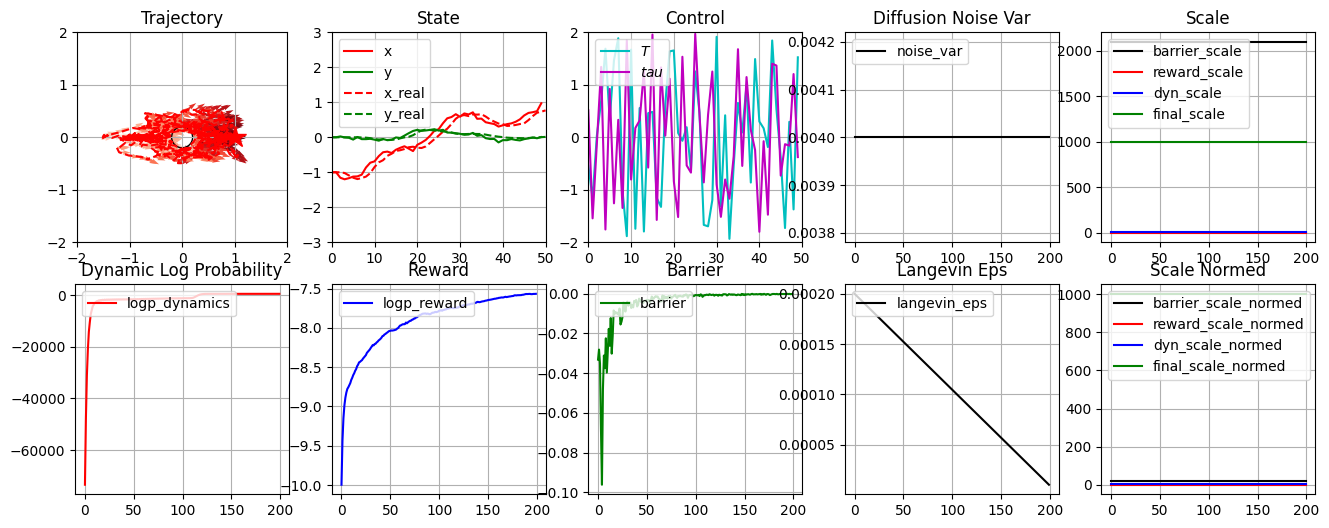

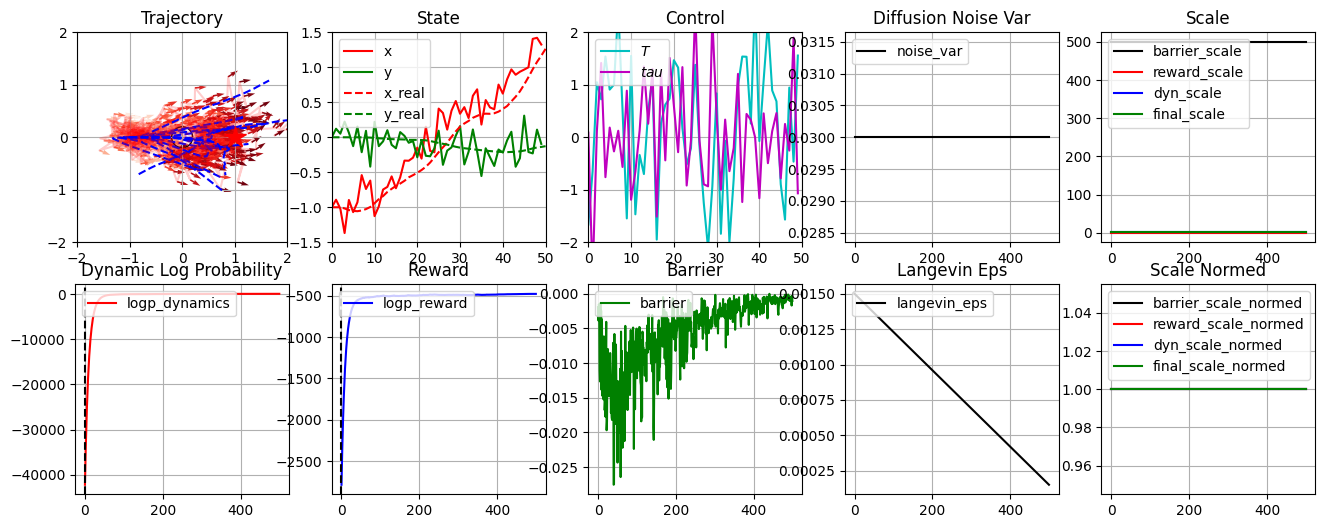

In [35]:
save_infos = []
save_grad_infos = []
update_traj_jit_x = jax.jit(update_traj_x)
update_traj_jit_u = jax.jit(update_traj_u)
get_logpd_scan_jit = jax.jit(get_logpd_scan)
get_barrier_jit = jax.jit(get_barrier)
get_reward_jit = jax.jit(get_reward)
get_final_constraint_jit = jax.jit(get_final_constraint)

for d_step in range(diffuse_step):
    
    # schedule noise_var
    noise_var = noise_var_schedule[d_step]
    # get values for dynamic, reward and barrier scale
    logpd = jax.vmap(get_logpd_scan_jit, in_axes=(0, 0, None))(
        x_traj, u_traj, params
    ).mean()
    reward = jax.vmap(get_reward_jit, in_axes=(0, 0, None))(
        x_traj, u_traj, params
    ).mean()
    barrier = jax.vmap(get_barrier_jit, in_axes=(0, None))(x_traj, params).mean()
    final = jax.vmap(get_final_constraint_jit, in_axes=(0, None))(x_traj, params).mean()
    # schedule dynamic, reward and barrier scale
    # reward_scale = 1.0
    dyn_scale = params.dyn_scale + jnp.clip(jnp.exp(-logpd / 1000.0) - 1.0, -1.0, 3.0)
    # dyn_scale = params.dyn_scale + jnp.clip(-logpd / 1000.0, -10.0, 10.0)
    dyn_scale = jnp.maximum(dyn_scale, 0.0)
    barrier_scale = params.barrier_scale + jnp.clip(jnp.exp(-barrier / 1.0) - 1.0, -1.0, 1.0) 
    barrier_scale = jnp.maximum(barrier_scale, 0.0)
    final_scale = params.final_scale + jnp.clip(jnp.exp(-final / 1.0) - 1.0, -1.0, 1000.0) 
    fiinal_scale = params.final_scale
    final_scale = jnp.maximum(final_scale, 0.0)

    barrier_scale = params.barrier_scale
    final_scale = params.final_scale
    reward_scale = params.reward_scale
    dyn_scale = params.dyn_scale

    params = params.replace(barrier_scale=barrier_scale, noise_var=noise_var, dyn_scale=dyn_scale, final_scale=final_scale
    )

    for sub_step in range(diffuse_substeps):

        # schedule langevin_eps
        langevin_eps = langevin_eps_schedule[sub_step] * (params.noise_var / 2e-5)
        params = params.replace(langevin_eps=langevin_eps)
        
        # update trajectory
        rng, rng_traj = jax.random.split(rng)
        # rollout dynamics to get real trajectory
        x_traj_real = jax.vmap(rollout, in_axes=(0, 0, None))(
            x_traj[:, 0], u_traj, params
        )
        save_infos.append([x_traj[:saved_batch_size], x_traj_real[:saved_batch_size]])
        for u_indx in range(2):
            u_traj, logpd_grad_u  = jax.vmap(update_traj_jit_u, in_axes=(0, 0, None, 0))(
                x_traj, u_traj, params, jax.random.split(rng, batch_size)
            )
        x_traj, logpd_grad_x, barrier_grad_x  = jax.vmap(update_traj_jit_x, in_axes=(0, 0, None, 0))(
            x_traj, u_traj, params, jax.random.split(rng, batch_size)
        )
        save_grad_infos.append([logpd_grad_x[:saved_batch_size], barrier_grad_x[:saved_batch_size], logpd_grad_u[:saved_batch_size]])
        x_traj = jnp.clip(x_traj, -2.5, 2.5)
        u_traj = jnp.clip(u_traj, -2.0, 2.0)

        logpd = jax.vmap(get_logpd_scan_jit, in_axes=(0, 0, None))(
            x_traj, u_traj, params 
        ).mean()
        logp_reward = jax.vmap(get_reward_jit, in_axes=(0, 0, None))(
            x_traj, u_traj, params
        ).mean()
        barrier_value = jax.vmap(get_barrier_jit, in_axes=(0, None))(
            x_traj, params
        ).mean()
        final_value = jax.vmap(get_final_constraint_jit, in_axes=(0, None))(
            x_traj, params
        ).mean()

        # log info
        log_info["d_step"] = d_step
        log_info["sub_step"] = sub_step
        log_info["total_step"] = d_step * diffuse_substeps + sub_step
        def set_log_info(key, value, log_info):
            log_info[key] = log_info[key].at[d_step * diffuse_substeps + sub_step].set(value)
            return log_info
        log_info = set_log_info("logpd", logpd, log_info)
        log_info = set_log_info("logp_reward", logp_reward, log_info)
        log_info = set_log_info("barrier", barrier_value, log_info)
        log_info = set_log_info("barrier_scale", params.barrier_scale, log_info)
        log_info = set_log_info("barrier_scale_normed", params.barrier_scale / default_params.barrier_scale, log_info)
        log_info = set_log_info("dyn_scale", params.dyn_scale, log_info)
        log_info = set_log_info("dyn_scale_normed", params.dyn_scale / default_params.dyn_scale, log_info)
        log_info = set_log_info("final_scale", params.final_scale, log_info)
        log_info = set_log_info("final_scale_normed", params.final_scale / default_params.final_scale, log_info)
        log_info = set_log_info("reward_scale", params.reward_scale, log_info)
        log_info = set_log_info("reward_scale_normed", params.reward_scale / default_params.reward_scale, log_info)
        log_info = set_log_info("noise_var", noise_var, log_info)
        log_info = set_log_info("langevin_eps", langevin_eps, log_info)

        # tensorboard
        writer.add_scalar("barrier", barrier_value, d_step * diffuse_substeps + sub_step)
        writer.add_scalar("barrier_scale", params.barrier_scale, d_step * diffuse_substeps + sub_step)
        writer.add_scalar("barrier_scale_normed", params.barrier_scale / default_params.barrier_scale, d_step * diffuse_substeps + sub_step)
        writer.add_scalar("dyn", logpd, d_step * diffuse_substeps + sub_step)
        writer.add_scalar("dyn_scale", params.dyn_scale, d_step * diffuse_substeps + sub_step)
        writer.add_scalar("dyn_scale_normed", params.dyn_scale / default_params.dyn_scale, d_step * diffuse_substeps + sub_step)
        writer.add_scalar("final", final_value, d_step * diffuse_substeps + sub_step)
        writer.add_scalar("final_scale", params.final_scale, d_step * diffuse_substeps + sub_step)
        writer.add_scalar("final_scale_normed", params.final_scale / default_params.final_scale, d_step * diffuse_substeps + sub_step)
        writer.add_scalar("reward", logp_reward, d_step * diffuse_substeps + sub_step)
        writer.add_scalar("reward_scale", params.reward_scale, d_step * diffuse_substeps + sub_step)
        writer.add_scalar("reward_scale_normed", params.reward_scale / default_params.reward_scale, d_step * diffuse_substeps + sub_step)
        writer.add_scalar("noise_var", noise_var, d_step * diffuse_substeps + sub_step)
        writer.add_scalar("langevin_eps", langevin_eps, d_step * diffuse_substeps + sub_step)

        jax.debug.print(
            "d_step = {d_step}, substep = {substep}, logp_dynamic = {x:.2f}, logp_reward = {y:.2f}, barrier = {z:.2f}",
            d_step=d_step,
            substep=sub_step,
            x=logpd,
            y=logp_reward,
            z=barrier_value,
        )

        
        
    # visualize trajectory
    clear_output()
    fig, axes = plt.subplots(2, 5, figsize=(16, 6))
    plot_traj(
        fig,
        axes,
        x_traj[:saved_batch_size],
        u_traj[:saved_batch_size],
        x_traj_real[:saved_batch_size],
        log_info,
        "",
    )
    



ffmpeg version 6.1.1 Copyright (c) 2000-2023 the FFmpeg developers
  built with Apple clang version 15.0.0 (clang-1500.1.0.2.5)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/6.1.1_3 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags='-Wl,-ld_classic' --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libharfbuzz --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libssh --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libopen

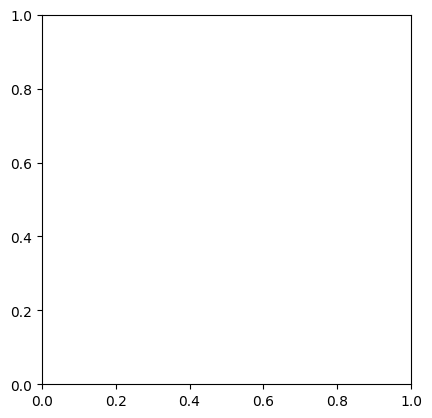

In [33]:
fig, ax = plt.subplots(1, 1)
# for info in save_infos:
for (i, (x_traj, x_traj_real)) in enumerate(save_infos):
    # if i % 10 != 0:
    #     continue
    if obstacle == 'square':
        rect = plt.Rectangle((-0.2, -0.2), 0.4, 0.4, color="black", fill=False)
        ax.add_artist(rect)
    elif obstacle == 'wall':
        rect = plt.Rectangle((-0.2, -0.5), 0.4, 1.0, color="black", fill=False)
        ax.add_artist(rect)
    elif obstacle == 'umaze':
        rect1 = plt.Rectangle((-1.0-0.5, 1.0-0.5), 2.0, 1.0, color="black", fill=True)
        rect2 = plt.Rectangle((-0.5, -1.0-0.5), 1.0, 3.0, color="black", fill=True)
        rect3 = plt.Rectangle((-1.0-0.5, -1.0-0.5), 2.0, 1.0, color="black", fill=True)
        ax.add_artist(rect1)
        ax.add_artist(rect2)
        ax.add_artist(rect3)
    elif obstacle == 'sphere':
        circle = plt.Circle((0, 0), 0.2, color="black", fill=False)
        ax.add_artist(circle)
    for j in range(x_traj.shape[0]):
        if task == 'point':
            ax.scatter(
                x_traj[j, :, 0],
                x_traj[j, :, 1],
                c=range(horizon),
                cmap="Reds",
                marker="o",
                alpha=1.0,
            )
        elif task == 'drone':
            ax.quiver(
                x_traj[j, :, 0],
                x_traj[j, :, 1],
                jnp.cos(x_traj[j, :, 2]),
                jnp.sin(x_traj[j, :, 2]),
                range(horizon),
                cmap="Reds",
                alpha=1.0,
            )
        ax.plot(
            x_traj[j, :, 0],
            x_traj[j, :, 1],
            "r",
            alpha=0.2,
        )
        ax.plot(
            x_traj_real[j, :, 0],
            x_traj_real[j, :, 1],
            "b--",
        )
        ax.quiver(
            x_traj[j, :,0],
            x_traj[j, :,1],
            logpd_grad_x[j,:,0],
            logpd_grad_x[j,:,1],
            color='r',
            width = 0.002,
            headwidth = 2.5,
        )
        ax.quiver(
            x_traj[j, :,0],
            x_traj[j, :,1],
            barrier_grad_x[j,:,0],
            barrier_grad_x[j,:,1],
            color='g',
            width = 0.002,
            headwidth = 2.5,
        )
        
    ax.grid()
    ax.set_xlim([-2, 2])
    ax.set_ylim([-2, 2])
    ax.set_aspect("equal", adjustable="box")
    # plot star at [1, 0]
    ax.plot(1.0, 0.0, "r*", markersize=16)
    # set title
    ax.set_title("Trajectory")
    # save figure to file
    plt.savefig(f"figure/{i}.png")
    
    ax.clear()

# render video
!rm figure/render.mp4
!ffmpeg -framerate 30 -i figure/%d.png -c:v libx264 -pix_fmt yuv420p figure/render.mp4
!rm figure/*.png

4


[-1.         -0.94136244 -0.9414516  -0.74672335 -0.7172046  -0.62069815
 -0.41540638 -0.38186926 -0.37624645 -0.2481945  -0.22588988 -0.21376084
 -0.34553674 -0.40545034 -0.46120346 -0.5306492  -0.6408049  -0.6033144
 -0.6191378  -0.51320463 -0.4217846  -0.4145271  -0.47815534 -0.45179453
 -0.39247984 -0.40941253 -0.37556064 -0.15241332  0.02471627  0.16261393
  0.31775072  0.4884034   0.61661     0.7055156   0.8565996   0.90824515
  0.99444395  1.0348766   1.0699782   1.0507245   0.97281617  1.0454314
  1.00175     0.98556554  0.9130222   0.80283076  0.7828468   0.68118054
  0.7358835   0.99239683]


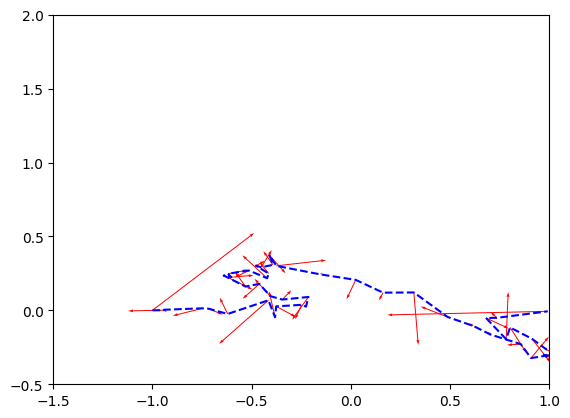

In [37]:
fig, ax = plt.subplots(1, 1)
j=4
print(j)
ax.set_xlim([-1.5, 1.0])
ax.set_ylim([-0.5, 2])
ax.plot(
            x_traj[j, :, 0],
            x_traj[j, :, 1],
            "b--",
        )
ax.quiver(
            x_traj[j, :,0],
            x_traj[j,:,1],
            logpd_grad_x[j,:,0],
            logpd_grad_x[j,:,1],
            width = 0.002,
            headwidth=3,
            color='r',)
ax.quiver(
            x_traj[j, :,0],
            x_traj[j,:,1],
            barrier_grad_x[j,:,0],
            barrier_grad_x[j,:,1],
            width = 0.006,
            headwidth=3,
            color='g',)

print(x_traj[j,:,0])

In [38]:
print(j)
j=0
ax.set_xlim([-1.5, 0.5])
ax.set_ylim([-0.5, 1.5])
ax.plot(
            x_traj[j, :, 0],
            x_traj[j, :, 1],
            "b",
        )
ax.quiver(
            x_traj[j, :,0],
            x_traj[j,:,1],
            logpd_grad_x[j,:,0],
            logpd_grad_x[j,:,1],
            width = 0.002,
            headwidth=3,
            color='r',)
ax.quiver(
            x_traj[j, :,0],
            x_traj[j,:,1],
            barrier_grad_x[j,:,0],
            barrier_grad_x[j,:,1],
            width = 0.006,
            headwidth=3,
            color='g',)

print(x_traj[j,:,0])

4
[-1.         -1.0025957  -1.1516649  -1.188767   -1.1753979  -1.1223668
 -1.1224405  -1.0749052  -0.86507946 -0.71924764 -0.68870395 -0.53289
 -0.42635748 -0.41246706 -0.4567642  -0.35853994 -0.29829952 -0.2550625
 -0.32429165 -0.3860602  -0.21569696 -0.15756592 -0.0742412   0.04757692
  0.18537082  0.22927457  0.39997774  0.5426552   0.58397955  0.65948653
  0.5967275   0.6836787   0.64927095  0.7115417   0.52878624  0.5396966
  0.42740464  0.4026003   0.37625754  0.3101153   0.3536201   0.378897
  0.3988464   0.44242972  0.5097453   0.6188551   0.6964854   0.7216845
  0.7496561   0.96805924]


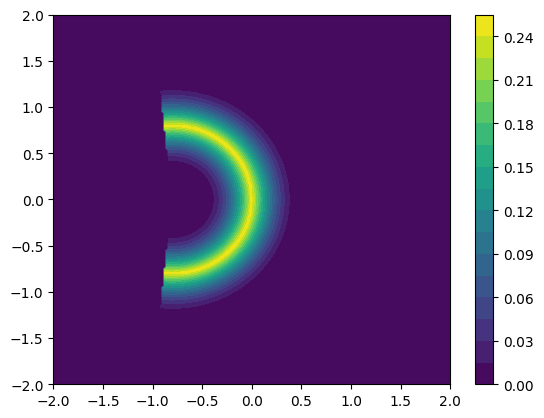

In [39]:
half_width = 0.75
def get_barrier_cost(x: jnp.ndarray) -> jnp.ndarray:
    q = x[:2]
    half_width = 0.5
    # Circle center jax array
    circle_center = jnp.array([-0.8, 0.0])
    dist2points = jnp.abs(0.8 - jnp.linalg.norm(q-circle_center, ord=2))
    theta = jnp.abs(jnp.arctan2(q[1]-circle_center[1], q[0]-circle_center[0]))
    half_switch = (theta < jnp.pi/2 + 0.1) * (theta > -jnp.pi/2 - 0.1)
    theta = jnp.clip(theta, 0.0, jnp.pi/2) 
    
    return jnp.clip((half_width-dist2points), 0.0, half_width)**2 *  half_switch

X = jnp.linspace(-2.0, 2.0, 200)
Y = jnp.linspace(-2.0, 2.0, 200)
X, Y = jnp.meshgrid(X, Y)
XY = jnp.stack([X, Y], axis=-1)
Z = jax.vmap(jax.vmap(get_barrier_cost))(XY)
plt.contourf(X, Y, Z, levels=20)
plt.colorbar()

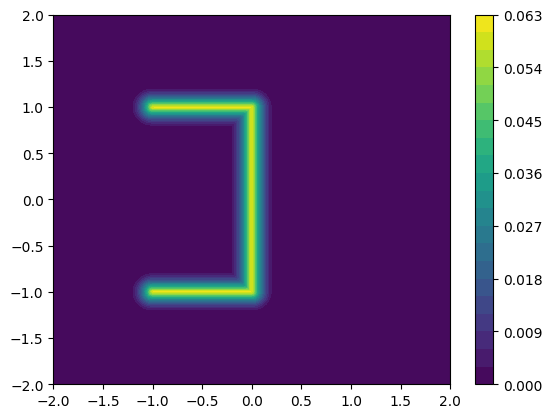

In [40]:
keypoints = jnp.array([
        [-1.0, 1.0], 
        [0.0, 1.0], 
        [0.0, -1.0],
        [-1.0, -1.0]
    ])
def get_barrier_cost(x: jnp.ndarray) -> jnp.ndarray:
       q = x[:2]
       half_width = 0.25
       dist2points = jnp.linalg.norm(q - keypoints, axis=1, ord=2)
       dist1 = (q[0] < keypoints[0,0]) * dist2points[0] + (q[0] > keypoints[1,0]) * dist2points[1] + (q[0] >= keypoints[0,0]) * (q[0] <= keypoints[1,0]) * jnp.abs(q[1] - keypoints[0,1])
       dist2 = (q[1] < keypoints[2,1]) * dist2points[2] + (q[1] > keypoints[1,1]) * dist2points[1] + (q[1] >= keypoints[2,1]) * (q[1] <= keypoints[1,1]) * jnp.abs(q[0]-keypoints[1,0])
       dist3 = (q[0] < keypoints[3,0]) * dist2points[3] + (q[0] > keypoints[2,0]) * dist2points[2] + (q[0] >= keypoints[3,0]) * (q[0] <= keypoints[2,0]) * jnp.abs(q[1] - keypoints[2,1])
       dist2_tort = dist2 * (jnp.abs(q[1])+1.0)
       dist1_tort = dist1 * jnp.clip((-q[0]+2),2.0,3.0)
       dist3_tort = dist3 * jnp.clip((-q[0]+2),2.0,3.0)
       dist2mazecenter = jnp.min(jnp.array([dist1, dist2, dist3]))
       return jnp.clip((half_width-dist2mazecenter), 0.0,half_width)**2
X = jnp.linspace(-2.0, 2.0, 200)
Y = jnp.linspace(-2.0, 2.0, 200)
X, Y = jnp.meshgrid(X, Y)
XY = jnp.stack([X, Y], axis=-1)
Z = jax.vmap(jax.vmap(get_barrier_cost))(XY)
plt.contourf(X, Y, Z, levels=20)
plt.colorbar()